<a href="https://colab.research.google.com/github/shawar8/Facial-Expression-Detection/blob/master/facial_expressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten , Dropout, MaxPooling2D
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, callbacks
from collections import Counter
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
os.chdir('./drive/My Drive/face_expression')

In [4]:
fer = pd.read_csv('./fer2013.csv')

In [5]:
fer.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
train = fer.query('Usage == "Training"')
val = fer.query('Usage == "PrivateTest"')
test = fer.query('Usage == "PublicTest"')

In [7]:
width = 48
height= 48

In [8]:
### Looping over the images, applying histogram equalization, and reshaping to 
### 48x48x1 array

def get_img_labels(df, width, height):
    images = []
    labels = []
    for key, values in df.iterrows():
        label = values[0]
        img = values[1]
        labels.append(label)
        img = np.array(img.split(' ')).astype(float)
        image_histogram, bins = np.histogram(img, 256, density=True)
        cdf = image_histogram.cumsum() # cumulative distribution function
        cdf = 255 * cdf / cdf[-1]
        image_equalized = np.interp(img, bins[:-1], cdf).reshape((width,height))
        images.append(image_equalized)
    return np.array(images), np.array(labels)

In [9]:
### Calling the function to get the train,val and test dataset
x_train, y_train = get_img_labels(train, width, height)
x_val, y_val = get_img_labels(val, width, height)
x_test, y_test = get_img_labels(test, width, height)

In [10]:
### Reshaping to a format that can be taken into the CNN Model
x_train = x_train.reshape((-1, width, height, 1))
x_val = x_val.reshape((-1, width, height, 1))
x_test = x_test.reshape((-1, width, height, 1))

In [11]:
### Creating a mapping for the emotions
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_map_rev = {j:i for i,j in emotion_map.items()}

In [12]:
### Checking to see if there is a similar distribution for each class in the train, val and test set
print ('y-train distribution')
train_count = (Counter([emotion_map[i] for i in y_train]))
train_dict = {i: str(np.round(j*100/sum(train_count.values())))+'%' for i,j in train_count.items()}
print (train_dict, '\n')
print ('y-val distribution')
val_count =  (Counter([emotion_map[i] for i in y_val]))
val_dict = {i: str(np.round(j*100/sum(val_count.values())))+'%' for i,j in val_count.items()}
print (val_dict, '\n')
print ('y-test distribution')
test_count = (Counter([emotion_map[i] for i in y_test]))
test_dict = {i: str(np.round(j*100/sum(test_count.values())))+'%' for i,j in test_count.items()}
print (test_dict)

y-train distribution
{'Angry': '14.0%', 'Fear': '14.0%', 'Sad': '17.0%', 'Neutral': '17.0%', 'Happy': '25.0%', 'Surprise': '11.0%', 'Disgust': '2.0%'} 

y-val distribution
{'Angry': '14.0%', 'Surprise': '12.0%', 'Neutral': '17.0%', 'Sad': '17.0%', 'Fear': '15.0%', 'Happy': '24.0%', 'Disgust': '2.0%'} 

y-test distribution
{'Angry': '13.0%', 'Disgust': '2.0%', 'Sad': '18.0%', 'Neutral': '17.0%', 'Happy': '25.0%', 'Fear': '14.0%', 'Surprise': '12.0%'}


In [13]:
### Plotting random images of chosen emotions
def get_image_samples(x_data, y_labels, label, num_images, x_imgs, y_imgs, img_labels):
  num_class_images = x_data[y_labels == [img_labels[label]]].shape[0]
  random_samples = np.random.randint(0,num_class_images,num_images)
  sample_imgs = x_data[y_labels == img_labels[label]][random_samples]
  x_dim = (48* x_imgs) + ((x_imgs - 1) * 2)
  y_dim = (48 *y_imgs) + ((y_imgs - 1) * 2)
  plot_ = np.zeros((x_dim, y_dim, 3))
  counter = 0
  for i in range(0, x_imgs):
    for j in range(0, y_imgs):
      plot_[(i*2)+(i*48): (i*2)+(i*48)+48, (j*2)+(j*48):(j*2)+(j*48)+48,:] = sample_imgs[counter]
      counter += 1
  plt.imshow(plot_)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


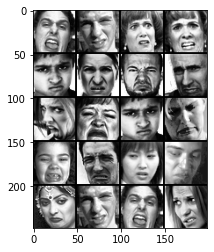

In [14]:
get_image_samples(x_train/255, y_train, 'Disgust', 20, 5, 4, emotion_map_rev)

In [15]:
### One hot encoding the labels
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [16]:
### I decided to combine the train and val dataset to create one big train dataset
x_train = np.concatenate([x_train, x_val], axis = 0)
y_train = np.concatenate([y_train, y_val], axis = 0)

In [17]:
### Normalizing the data so that all values are between 0 and 1
x_train = x_train/255.
x_test = x_test/255.

In [18]:
### Defining the batch_size, optimizer, regularizer for the input layer, labels and epochs
batch_size = 64
opt = optimizers.Adam(learning_rate = 1e-4)
reg = tensorflow.keras.regularizers.l2(0.01)
num_labels = 7
epochs = 30

In [19]:
### Creating a data generator to create more data with flipping the faces horizontally and a little zoom
train_datagen = ImageDataGenerator(horizontal_flip= True, zoom_range = 0.1)
train_datagen.fit(x_train)
datagen_flow = train_datagen.flow(x_train, y_train, batch_size = batch_size)

In [21]:
### Building the model
model = models.Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), kernel_regularizer=reg))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [ ]:
### If you dont want to run the model, just load the weights
model.load_weights('face_emotions.h5')

In [ ]:
history = model.fit(datagen_flow, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_test, y_test))

In [24]:
###Loading pre-trained face detector model and its weights
model_path = './res10_300x300_ssd_iter_140000.caffemodel'
model_prototxt_path = './deploy.prototxt'

detector = cv2.dnn.readNetFromCaffe(model_prototxt_path, model_path)

In [27]:
### Piecing everything together to load the video, detect the face, predict
### the emotion, draw a rectangle around the face and print the emotion detected

from google.colab.patches import cv2_imshow
import imutils
import imageio
vc = cv2.VideoCapture('emotion3.mov')
writer = imageio.get_writer('./latest_emotion_detect.mov')
while True:
  ret, frame = vc.read()
  if not ret:
    break
  else:
    frame = imutils.resize(frame, width = 600)
    h,w = frame.shape[:2]
    ### Creating a blob from the image -> https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    detector.setInput(blob)
    detections = detector.forward()
    ### Looping over the face detenctions and making the prediction only if the detection confidence > 0.6
    for i in range(detections.shape[2]):
      confidence = detections[0,0,i,2]
      if confidence > 0.6:
        ### The coordinates of the box are normalized so we multiply by width and height to get actual coordinates
        box = detections[0,0,i,3:7] * np.array([w,h,w,h])
        x0, y0, x1, y1 = box.astype('int')
        ### Making sure the coordinates of the box are inside the picture frame
        x0 = max(0,x0)
        y0 = max(0, y0)
        x1 = min(x1, w)
        y1 = min(y1, h)
        ### Resizing the image to 48, 48 to feed into the neural network
        face = cv2.resize(frame[y0:y1, x0:x1], (48,48))
        gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)
        gray = gray/255.
        gray = img_to_array(gray)
        gray = np.expand_dims(gray, axis = 0)
        prediction = model.predict(gray)
        pred_prob = prediction.max()
        expression = emotion_map[np.argmax(prediction)]
        label = f'{np.int(pred_prob * 100)}% {expression}'
        ### Putting the text and drawing the rectangle
        cv2.putText(frame, label, (x0, y0-10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,255.), 2)
        cv2.rectangle(frame, (x0, y0), (x1,y1), (0,0,255.), 2)
    writer.append_data(cv2.cvtColor(frame,cv2.COLOR_RGB2BGR))
vc.release()
writer.close()